# GE Bracket

Geometry from the GE jet engine bracket challenge: https://grabcad.com/challenges/ge-jet-engine-bracket-challenge

Load cases considered in the optimization: 35.6 kN vertical force / 37.8 kN horizontal force

For numerical reasons, the force was rescaled by a factor of 0.01. Therefore, to obtain the actual compliance it is necessary to multiply the output by 10000 and to obtain the actual displament it is necessary to multiply the output by 100.

Ansys model:
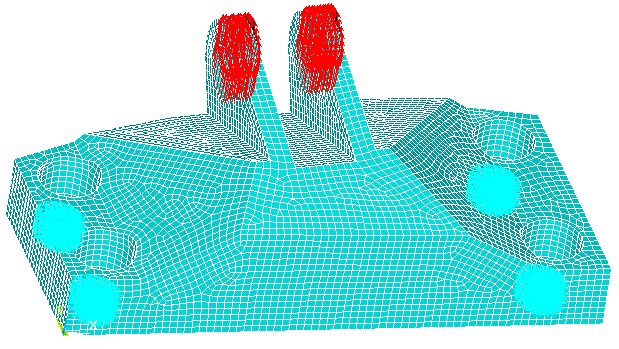

In [1]:
import os, sys
path = os.path.abspath(os.path.join('..'))
os.chdir(path)
if path not in sys.path:
    sys.path.append(path)

In [2]:
import matplotlib.pyplot as plt
import niceplots
plt.style.use(niceplots.get_style())

import pyvista as pv
pv.set_plot_theme('document')
pv.set_jupyter_backend('static')

import numpy as np
from optim import TopOpt, Post3D

In [3]:
# {t/mm^3, MPa, -, kgCO2/kg}
bamboo    = {'rho': 700e-12,  'E': 17.5e3,  'v': 0.39,  'CO2': 1.0565}
flax      = {'rho': 1470e-12, 'E': 53.5e3,  'v': 0.355, 'CO2': 0.44}
hemp      = {'rho': 1490e-12, 'E': 62.5e3,  'v': 0.275, 'CO2': 1.6}
hmcarbon  = {'rho': 2105e-12, 'E': 760e3,   'v': 0.105, 'CO2': 68.1}
# lmcarbon  = {'rho': 1820e-12, 'E': 242.5e3, 'v': 0.105, 'CO2': 20.3}
sglass    = {'rho': 2495e-12, 'E': 89.5e3,  'v': 0.22,  'CO2': 2.905}
# eglass    = {'rho': 2575e-12, 'E': 78.5e3,  'v': 0.22,  'CO2': 2.45}

# cellulose = {'rho': 990e-12,  'E': 3.25e3, 'v': 0.355, 'CO2': 3.8}
pla       = {'rho': 1290e-12, 'E': 3.45e3, 'v': 0.39,  'CO2': 2.28}
petg      = {'rho': 1270e-12, 'E': 2.06e3, 'v': 0.403, 'CO2': 4.375}
epoxy     = {'rho': 1255e-12, 'E': 2.41e3, 'v': 0.399, 'CO2': 5.94}
# polyester = {'rho': 1385e-12, 'E': 4.55e3, 'v': 0.35,  'CO2': 4.5}

names_f   = ['bamboo', 'flax', 'hemp', 'hmcarbon', 'sglass']
fibers    = [bamboo, flax, hemp, hmcarbon, sglass]

names_m   = ['pla', 'petg', 'epoxy']
matrices  = [pla, petg, epoxy]

CO2veh = 1030 * 25 * 3.83 # kg_fuel/kg_transported/year * years * kgCO2/kg_fuel = kgCO2/kg

In [ ]:
comp    = []
mass    = []
co2_mat = []
co2_tot = []
iter    = []
t       = []

for name_f, fiber in zip(names_f, fibers):
    for name_m, matrix in zip(names_m, matrices):
        Ex, Ey, nuxy, nuyz, Gxy, rho, CO2mat = TopOpt.rule_mixtures(fiber=fiber, matrix=matrix, Vfiber=0.5)

        jobname = '_'.join([name_f, name_m])
        solver = TopOpt(inputfile='models/bracket.db', load_cases=('models/bracket_ver.s01', 'models/bracket_hor.s01'), res_dir=f'results/workflow/material/{jobname}/',
            dim='3D_layer', jobname=jobname, echo=False)
        solver.set_material(Ex=Ex, Ey=Ey, nuxy=nuxy, nuyz=nuxy, Gxy=Gxy)
        solver.set_volfrac(0.2)
        solver.set_filters(r_rho=5, r_theta=7)
        solver.set_print_direction(print_direction=(0.,0.,1.))
        solver.set_initial_conditions('random')
        solver.set_optim_options(max_iter=50, tol=5e-3, continuation=True)

        region1 = np.where((solver.centers[:,0]-15.5)**2 + (solver.centers[:,1]-13.5)**2 < 8**2)[0]
        region2 = np.where((solver.centers[:,0]-15.2)**2 + (solver.centers[:,1]-51.8)**2 < 8**2)[0]
        region3 = np.where((solver.centers[:,0]-163.2)**2 + (solver.centers[:,1]-47.3)**2 < 8**2)[0]
        region4 = np.where((solver.centers[:,0]-163.2)**2 + (solver.centers[:,1]+4.9)**2 < 8**2)[0]
        region5 = np.where((solver.centers[:,1]-73)**2 + (solver.centers[:,2]-40.5)**2 < 15**2)[0]
        solid = np.concatenate([region1, region2, region3, region4, region5])
        solver.set_solid_elem(solid)

        solver.run()
        solver.save()

        comp    += [solver.comp_norm_max_hist[-1]]
        mass    += [1e6 * solver.get_mass(rho)]
        co2_mat += [1e3 * solver.get_mass(rho) * CO2mat]
        co2_tot += [1e3 * solver.get_CO2_footprint(rho, CO2mat, CO2veh)]
        iter    += [solver.mma.iter]
        t       += [solver.time]

        del solver

comp    = np.array(comp).reshape((len(fibers),len(matrices)))
mass    = np.array(mass).reshape((len(fibers),len(matrices)))
co2_mat = np.array(co2_mat).reshape((len(fibers),len(matrices)))
co2_tot = np.array(co2_tot).reshape((len(fibers),len(matrices)))
iter    = np.array(iter).reshape((len(fibers),len(matrices)))
t       = np.array(t).reshape((len(fibers),len(matrices)))

In [5]:
# comp = []
# mass = []
# co2  = []
# iter = []
# t    = []

# for name_f, fiber in zip(names_f, fibers):
#     for name_m, matrix in zip(names_m, matrices):
#         Ex, Ey, nuxy, nuyz, Gxy, rho, CO2mat = TopOpt.rule_mixtures(fiber=fiber, matrix=matrix, Vfiber=0.5)

#         jobname = '_'.join([name_f, name_m])
#         solver = TopOpt.load(f'results/material/{jobname}/topopt.json')

#         comp += [solver.comp_max_hist[-1]]
#         mass += [1e6 * solver.get_mass(rho)]
#         co2  += [1e3 * solver.get_CO2_footprint(rho, CO2mat, CO2veh)]
#         iter += [solver.mma.iter]
#         t    += [solver.time]

#         del solver

# comp = np.array(comp).reshape((len(fibers),len(matrices)))
# mass = np.array(mass).reshape((len(fibers),len(matrices)))
# co2  = np.array(co2).reshape((len(fibers),len(matrices)))
# iter = np.array(iter).reshape((len(fibers),len(matrices)))
# t    = np.array(t).reshape((len(fibers),len(matrices)))

In [6]:
print('-'*(21*8+1))
print(('|{:^20}'*8+'|').format('Fiber','Matrix','Compliance (N.mm)','Mass (g)','CO2_mat (kgCO2)','CO2_tot (kgCO2)','Iter','Time (s)'))
print('-'*(21*8+1))

for i, name_f in enumerate(names_f):
    for j, name_m in enumerate(names_m):
        print(('|{:^20}|{:^20}|{:^20.3f}|{:^20.3f}|{:^20.3f}|{:^20.3f}|{:^20}|{:^20.2f}|').format(name_f,name_m,comp[i][j],mass[i][j],co2_mat[i][j],co2_tot[i][j],iter[i][j],t[i][j]))

print('-'*(21*8+1))

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|       Fiber        |       Matrix       | Compliance (N.mm)  |      Mass (g)      |  CO2_mat (kgCO2)   |  CO2_tot (kgCO2)   |        Iter        |      Time (s)      |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|       bamboo       |        pla         |       35.601       |       88.357       |       0.163        |      8714.129      |         43         |      3740.15       |
|       bamboo       |        petg        |       53.112       |       86.815       |       0.277        |      8562.168      |         40         |      3571.26       |
|       bamboo       |       epoxy        |       45.797       |       86.708       |       0.363        |      8551.738      |         45         |  

In [ ]:
solver = TopOpt(inputfile='models/bracket.db', load_cases=('models/bracket_ver.s01', 'models/bracket_hor.s01'), res_dir='results/material/alu/',
    dim='SIMP3D', jobname='alu', echo=False)
solver.set_material(Ex=70e3, Ey=70e3, nuxy=0.3, nuyz=0.3, Gxy=26.9e3)
solver.set_volfrac(0.2)
solver.set_filters(r_rho=5, r_theta=7)
solver.set_print_direction(print_direction=(0.,0.,1.))
solver.set_initial_conditions('random')
solver.set_optim_options(max_iter=50, tol=5e-3, continuation=True)

region1 = np.where((solver.centers[:,0]-15.5)**2 + (solver.centers[:,1]-13.5)**2 < 8**2)[0]
region2 = np.where((solver.centers[:,0]-15.2)**2 + (solver.centers[:,1]-51.8)**2 < 8**2)[0]
region3 = np.where((solver.centers[:,0]-163.2)**2 + (solver.centers[:,1]-47.3)**2 < 8**2)[0]
region4 = np.where((solver.centers[:,0]-163.2)**2 + (solver.centers[:,1]+4.9)**2 < 8**2)[0]
region5 = np.where((solver.centers[:,1]-73)**2 + (solver.centers[:,2]-40.5)**2 < 15**2)[0]
solid = np.concatenate([region1, region2, region3, region4, region5])
solver.set_solid_elem(solid)

solver.run()
solver.save()

rho    = 2765e-12
CO2mat = 8.67
comp_alu    = solver.comp_norm_max_hist[-1]
mass_alu    = 1e6 * solver.get_mass(rho)
co2_mat_alu = 1e3 * solver.get_mass(rho) * CO2mat
co2_tot_alu = 1e3 * solver.get_CO2_footprint(rho, CO2mat, CO2veh)
iter_alu    = solver.mma.iter
t_alu       = solver.time

del solver

In [11]:
print('-'*(21*7+1))
print(('|{:^20}'*7+'|').format('','Compliance (N.mm)','Mass (g)','CO2_mat (kgCO2)','CO2_tot (kgCO2)','Iter','Time (s)'))
print('-'*(21*7+1))
print(('|{:^20}|{:^20.3f}|{:^20.3f}|{:^20.3f}|{:^20.3f}|{:^20}|{:^20.2f}|').format('Aluminium 2024',comp_alu,mass_alu,co2_mat_alu,co2_tot_alu,iter_alu,t_alu))
print('-'*(21*7+1))

----------------------------------------------------------------------------------------------------------------------------------------------------
|                    | Compliance (N.mm)  |      Mass (g)      |  CO2_mat (kgCO2)   |  CO2_tot (kgCO2)   |        Iter        |      Time (s)      |
----------------------------------------------------------------------------------------------------------------------------------------------------
|   Aluminium 2024   |       3.032        |      252.664       |       2.191        |     24920.551      |         43         |      1996.52       |
----------------------------------------------------------------------------------------------------------------------------------------------------


In [64]:
from scipy import interpolate
from scipy.spatial import ConvexHull

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

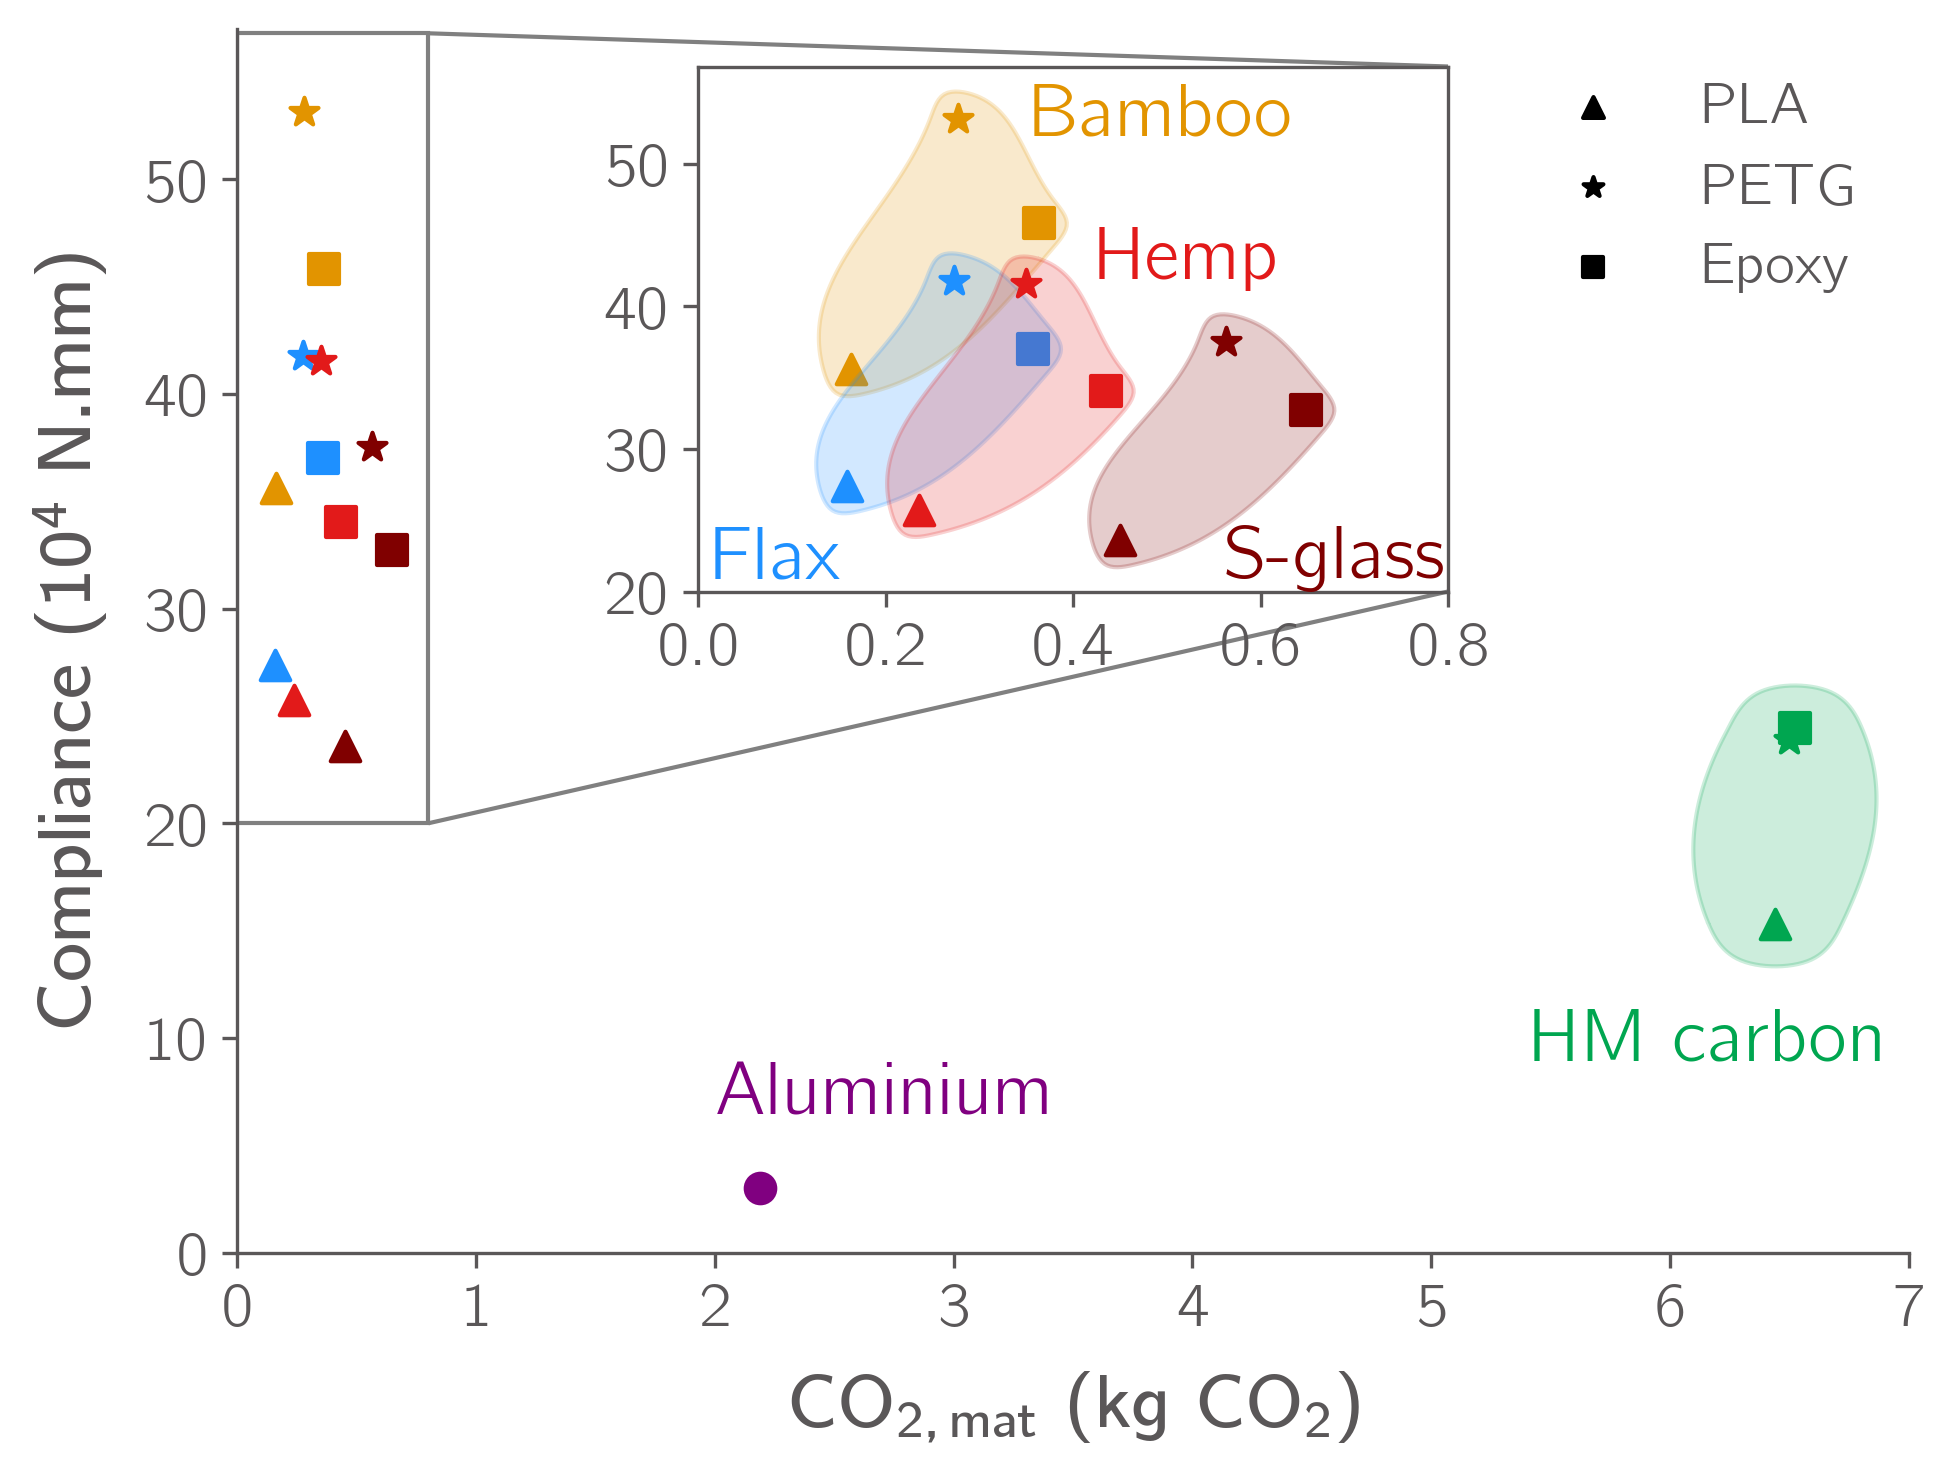

In [93]:
fig, ax = plt.subplots(dpi=300)
axins = inset_axes(ax, width=2.5, height=1.75, loc=9)
mark_inset(ax, axins, loc1=1, loc2=4, fc="none", ec="0.5")
axins.spines['top'].set_visible(True)
axins.spines['right'].set_visible(True)
axins.set_xlim((0, 0.8))
axins.set_ylim((20, 56.8))

colors = niceplots.get_colors_list()
markers = ['^','*','s','d','o']
labels_m = ['PLA', 'PETG', 'Epoxy']
labels_f = ['Bamboo', 'Flax', 'Hemp', 'HM carbon', 'S-glass']
labelpos = [(0.35,52), (0.01,21), (0.42,42), (5.4,9), (0.56,21)]
for i in range(len(fibers)):
    x = co2_mat[i,:]
    y = comp[i,:]
    
    for j in range(len(matrices)):
        ax.scatter(x[j], y[j], c=colors[i], marker=markers[j], s=50)
        if i != 3: axins.scatter(x[j], y[j], c=colors[i], marker=markers[j], s=50)

    points = []
    r = 0.04
    for x, y in zip(x,y):
        if i != 3: points += [[x/0.75 + np.cos(2*np.pi/6*s)*r, y/50+ np.sin(2*np.pi/6*s)*r] for s in range(7)]
        else: points += [[x/7 + np.cos(2*np.pi/6*s)*r, y/50+ np.sin(2*np.pi/6*s)*r] for s in range(7)]
    points = np.array(points)

    hull = ConvexHull(points)
    x_hull = np.append(points[hull.vertices,0],
                       points[hull.vertices,0][0])
    y_hull = np.append(points[hull.vertices,1],
                       points[hull.vertices,1][0])

    dist = np.sqrt((x_hull[:-1] - x_hull[1:])**2 + (y_hull[:-1] - y_hull[1:])**2)
    dist_along = np.concatenate(([0], dist.cumsum()))
    spline, u = interpolate.splprep([x_hull, y_hull], 
                                    u=dist_along, s=0, per=1)
    interp_d = np.linspace(dist_along[0], dist_along[-1], 200)
    interp_x, interp_y = interpolate.splev(interp_d, spline)

    if i != 3: axins.fill(0.75*interp_x, 50*interp_y, '--', c=colors[i], alpha=0.2)
    else: ax.fill(7*interp_x, 50*interp_y, '--', c=colors[i], alpha=0.2)

    if i != 3: axins.annotate(labels_f[i], xy=labelpos[i], color=colors[i])
    else: ax.annotate(labels_f[i], xy=labelpos[i], color=colors[i])

for j in range(len(matrices)):
    ax.scatter([], [], c='k', marker=markers[j], label=labels_m[j], s=25)

ax.scatter(co2_mat_alu, comp_alu, c=colors[len(fibers)+1], marker='o', s=50)
ax.annotate('Aluminium', xy=(2,6.5), color=colors[len(fibers)+1])

ax.set_ylabel(r'Compliance (10$^4$ N.mm)')
ax.set_xlabel(r'$CO_{2,mat}$ (kg CO$_2$)')
ax.set_ylim((0,57))
ax.set_xlim((0,7))
ax.legend(prop={"size":14},loc='upper right')
plt.show()

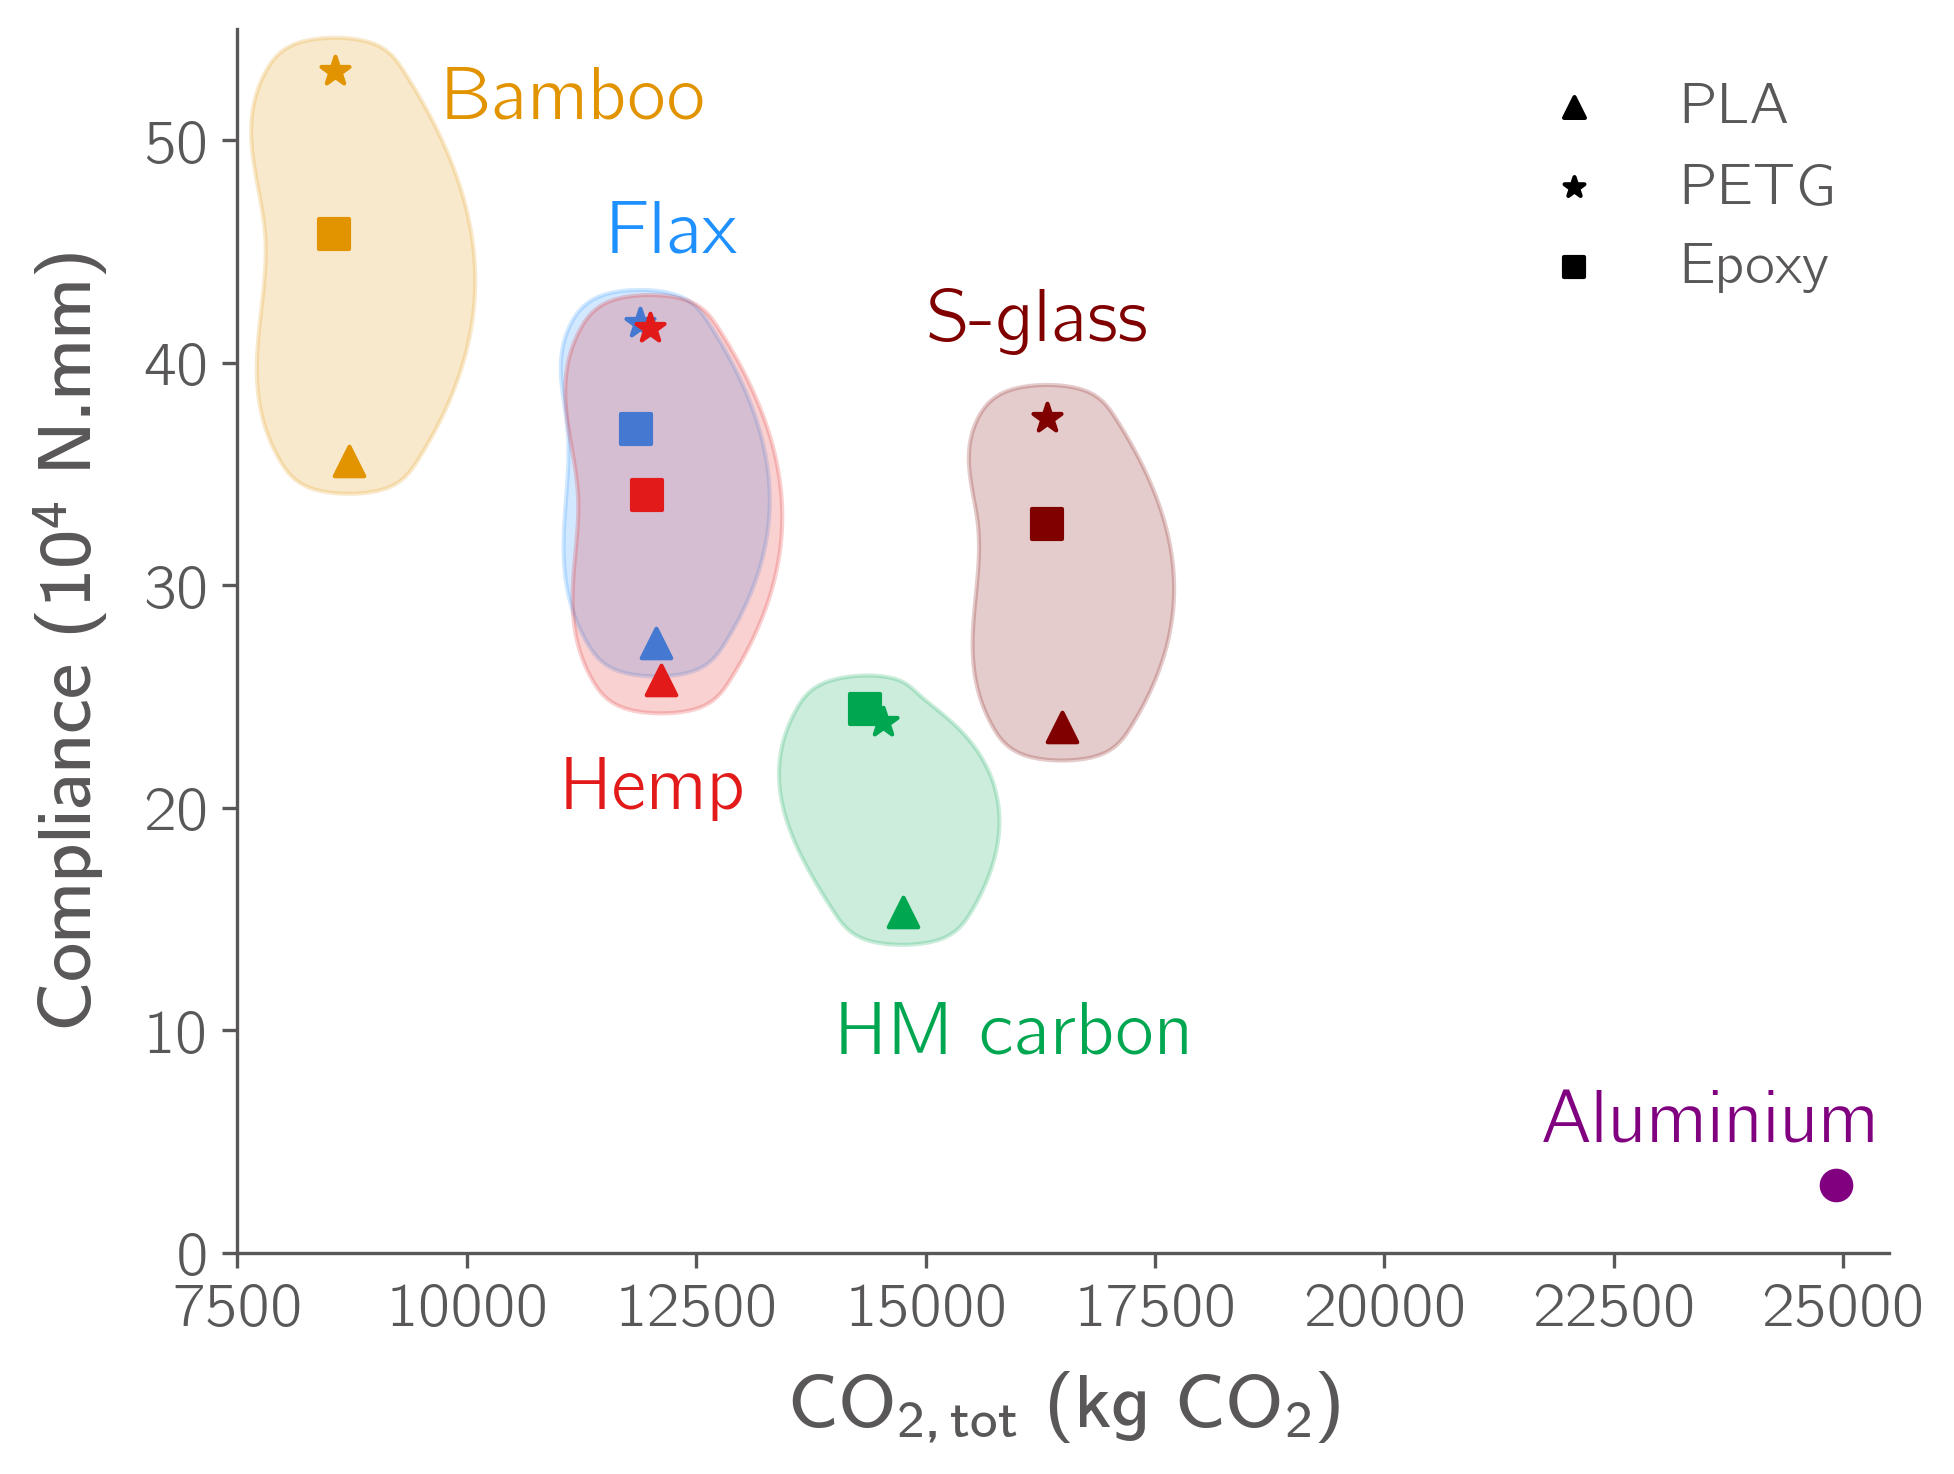

In [97]:
plt.figure(dpi=300)
colors = niceplots.get_colors_list()
markers = ['^','*','s','d','o']
labels_m = ['PLA', 'PETG', 'Epoxy']
labels_f = ['Bamboo', 'Flax', 'Hemp', 'HM carbon', 'S-glass']
labelpos = [(9700,51), (11500,45), (11000,20), (14000,9), (15000,41)]
for i in range(len(fibers)):
    x = co2_tot[i,:]
    y = comp[i,:]
    
    for j in range(len(matrices)):
        plt.scatter(x[j], y[j], c=colors[i], marker=markers[j], s=50)

    points = []
    r = 0.03
    for x, y in zip(x,y):
        points += [[x/25000 + np.cos(2*np.pi/6*s)*r, y/50+ np.sin(2*np.pi/6*s)*r] for s in range(7)]
    points = np.array(points)

    hull = ConvexHull(points)
    x_hull = np.append(points[hull.vertices,0],
                       points[hull.vertices,0][0])
    y_hull = np.append(points[hull.vertices,1],
                       points[hull.vertices,1][0])

    dist = np.sqrt((x_hull[:-1] - x_hull[1:])**2 + (y_hull[:-1] - y_hull[1:])**2)
    dist_along = np.concatenate(([0], dist.cumsum()))
    spline, u = interpolate.splprep([x_hull, y_hull], 
                                    u=dist_along, s=0, per=1)
    interp_d = np.linspace(dist_along[0], dist_along[-1], 200)
    interp_x, interp_y = interpolate.splev(interp_d, spline)

    plt.fill(25000*interp_x, 50*interp_y, '--', c=colors[i], alpha=0.2)

    plt.annotate(labels_f[i], xy=labelpos[i], color=colors[i])

for j in range(len(matrices)):
    plt.scatter([], [], c='k', marker=markers[j], label=labels_m[j], s=25)

plt.scatter(co2_tot_alu, comp_alu, c=colors[len(fibers)+1], marker='o', s=50)
plt.annotate('Aluminium', xy=(21700,5), color=colors[len(fibers)+1])

plt.ylabel(r'Compliance (10$^4$ N.mm)')
plt.xlabel(r'$CO_{2,tot}$ (kg CO$_2$)')
plt.ylim((0,55))
plt.xlim((7500,25500))
plt.legend(prop={"size":14},loc='upper right')
plt.show()